In [40]:
import argparse
import base64
import math
import cv2
import os
import sys
import shutil
import glob
import time
import json
import warnings
import yaml
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import trange
from sklearn.linear_model import LinearRegression
from scipy import ndimage, misc

In [41]:
sys.path.insert(0, "../image-segmentation-keras/dataset/")

# Zip results

In [42]:
# !zip -r results.zip results/

# Data Processing

In [43]:
def rotate(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = int(ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy))
    qy = int(oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy))
    return qx, qy

In [44]:
files = glob.glob(os.path.join("results", "*", "*"))

for i in trange(len(files)):
    f = files[i]
    
    img = cv2.imread(os.path.join(f, "img.jpg"), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    with open(os.path.join(f, "mask_rcnn_label.json")) as jf:
        json_info = json.load(jf)
        
    box = json_info["box"]
    mask_points = np.asarray(json_info["mask"])
    width, height = box[3]-box[1], box[2]-box[0]
    
    if width > height:
        margin = (width-width*0.5)/2
        r = [box[1] + margin, box[3] - margin]
        mask_points_in_range = mask_points[(mask_points[:,0]>r[0]) & (mask_points[:,0]<r[1]), :]
        
        X = np.unique(mask_points_in_range[:,0])
        mask_points_in_range = [mask_points_in_range[mask_points_in_range[:,0] == x,:] for x in X]
        
        # 上下兩排的點
        top_points = np.asarray([p[p[:,1] == p[:,1].min()][0] for p in mask_points_in_range])
        bottom_points = np.asarray([p[p[:,1] == p[:,1].max()][0] for p in mask_points_in_range])
        
        # 線性回歸
        top_regr = LinearRegression().fit(top_points[:,0].reshape(len(top_points),1), top_points[:,1])
        bottom_regr = LinearRegression().fit(bottom_points[:,0].reshape(len(bottom_points),1), bottom_points[:,1])
    
        top_coef, top_intercept = top_regr.coef_[0], top_regr.intercept_
        bottom_coef, bottom_intercept = bottom_regr.coef_[0], bottom_regr.intercept_

        coef = (top_coef + bottom_coef) / 2
        
        # intercept 修正
        top = np.argmax(top_points[:,0]*coef - top_points[:,1])
        top_point = top_points[top,:]
        top_intercept = top_point[1] - top_point[0]*coef
        
        bottom = np.argmin(bottom_points[:,0]*coef - bottom_points[:,1])
        bottom_point = bottom_points[bottom,:]
        bottom_intercept = bottom_point[1] - bottom_point[0]*coef
        
        # 畫出上下兩條線
        lined_img = img.copy()
        
        for p in top_points:
            lined_img = cv2.circle(lined_img, (p[0], p[1]), 5, (255, 0, 0), 2)
        
        for p in bottom_points:
            lined_img = cv2.circle(lined_img, (p[0], p[1]), 5, (255, 0, 0), 2)
            
        # TODO: coef == 0
        top_y1 = int((0*coef + top_intercept))
        top_y2 = int((2400*coef + top_intercept))
        lined_img = cv2.line(lined_img, (0, top_y1), (2400, top_y2), (255,0,0), 2)
        
        # TODO: coef == 0
        bottom_y1 = int((0*coef + bottom_intercept))
        bottom_y2 = int((2400*coef + bottom_intercept))
        lined_img = cv2.line(lined_img, (0, bottom_y1), (2400, bottom_y2), (255,0,0), 2)

        # image output
        lined_img = Image.fromarray(lined_img)
        lined_img.save(os.path.join(f, "lined_img.jpg"))

        # 計算角度
        x1, y1 = 0, 1
        x2, y2 = 1, coef
        a = 1
        b = (x2**2+y2**2)**(1/2)
        c = ((x1-x2)**2+(y1-y2)**2)**(1/2)
        cos = (c**2-a**2-b**2)/(-2*a*b)
        theta = math.degrees(math.acos(cos))
        
        # Rotate
        rotated_img = Image.open(os.path.join(f, "img.jpg"))
        center = (1200, 1200)
        rotated_img = rotated_img.rotate(-theta, center=center)
        rotated_img.save(os.path.join(f, "rotated_img.jpg"))
    
        # Crop copper region
        left_point = mask_points[mask_points[:,0] == mask_points[:,0].min()][0]
        right_point = mask_points[mask_points[:,0] == mask_points[:,0].max()][0]
        
        img = cv2.imread(os.path.join(f, "rotated_img.jpg"), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x1, _ = rotate(center, (0,top_y1), theta*math.pi/180)
        x2, _ = rotate(center, (0,bottom_y1), theta*math.pi/180)
        _, y1 = rotate(center, (left_point[0],left_point[1]), theta*math.pi/180)
        _, y2 = rotate(center, (right_point[0],right_point[1]), theta*math.pi/180)
        
        x1, x2 = sorted([x1, x2])
        y1, y2 = sorted([y1, y2])
        padding = int((y2-y1)*0.1)
        img = img[y1-padding:y2+padding,x1:x2,:]
        cropped_img = Image.fromarray(img)
        cropped_img.save(os.path.join(f, "cropped_img.jpg"))
    
        # Crop to top % bottom
        w = x2-x1
        img_1 = img[:w,:,:]
        img_2 = img[-w:,:,:]
        img_1 = Image.fromarray(img_1)
        img_1.save(os.path.join(f, "img_1.jpg"))
        img_2 = Image.fromarray(img_2)
        img_2.save(os.path.join(f, "img_2.jpg"))
    else:
        margin = (height-height*0.5)/2
        r = [box[0] + margin, box[2] - margin]
        mask_points_in_range = mask_points[(mask_points[:,1]>r[0]) & (mask_points[:,1]<r[1]), :]
        
        X = np.unique(mask_points_in_range[:,1])
        mask_points_in_range = [mask_points_in_range[mask_points_in_range[:,1] == x,:] for x in X]
        
        # 左右兩排的點
        left_points = np.asarray([p[p[:,0] == p[:,0].min()][0] for p in mask_points_in_range])
        right_points = np.asarray([p[p[:,0] == p[:,0].max()][0] for p in mask_points_in_range])

        # 線性回歸
        left_points_min, left_points_max = left_points[:,0].min(), left_points[:,0].max()
        if left_points_max - left_points_min < 20:
            left_coef, left_intercept = None, None
        else:
            left_regr = LinearRegression().fit(left_points[:,0].reshape(len(left_points),1), left_points[:,1])
            left_coef, left_intercept = left_regr.coef_[0], left_regr.intercept_
        
        right_points_min, right_points_max = right_points[:,0].min(), right_points[:,0].max()
        if right_points_max - right_points_min < 20:
            right_coef, right_intercept = None, None
        else:
            right_regr = LinearRegression().fit(right_points[:,0].reshape(len(right_points),1), right_points[:,1])
            right_coef, right_intercept = right_regr.coef_[0], right_regr.intercept_
        
        if (left_coef is None) | (right_coef is None):
            coef = None
        else:
            coef = (left_coef + right_coef) / 2
        
        if coef is not None:
            # intercept 修正
            left = np.argmax(left_points[:,0]*coef - left_points[:,1])
            left_point = left_points[left,:]
            left_intercept = left_point[1] - left_point[0]*coef

            right = np.argmin(right_points[:,0]*coef - right_points[:,1])
            right_point = right_points[right,:]
            right_intercept = right_point[1] - right_point[0]*coef

        # 畫出左右兩條線
        lined_img = img.copy()

        for p in left_points:
            lined_img = cv2.circle(lined_img, (p[0], p[1]), 5, (255, 0, 0), 2)

        for p in right_points:
            lined_img = cv2.circle(lined_img, (p[0], p[1]), 5, (255, 0, 0), 2)
        
        if coef is None:
            lined_img = cv2.line(lined_img, (left_points_min, 0), (left_points_min, 2400), (255,0,0), 2)
            lined_img = cv2.line(lined_img, (right_points_max, 0), (right_points_max, 2400), (255,0,0), 2)
        else:
            # TODO: coef == 0
            left_y1 = int((0*coef + left_intercept))
            left_y2 = int((2400*coef + left_intercept))
            lined_img = cv2.line(lined_img, (0, left_y1), (2400, left_y2), (255,0,0), 2)

            # TODO: coef == 0
            right_y1 = int((0*coef + right_intercept))
            right_y2 = int((2400*coef + right_intercept))
            lined_img = cv2.line(lined_img, (0, right_y1), (2400, right_y2), (255,0,0), 2)

        # image output
        lined_img = Image.fromarray(lined_img)
        lined_img.save(os.path.join(f, "lined_img.jpg"))

        if coef is None:
            rotated_img = Image.open(os.path.join(f, "img.jpg"))
            rotated_img.save(os.path.join(f, "rotated_img.jpg"))
        else:
            # 計算角度
            x1, y1 = 0, 1
            x2, y2 = 1, coef
            a = 1
            b = (x2**2+y2**2)**(1/2)
            c = ((x1-x2)**2+(y1-y2)**2)**(1/2)
            cos = (c**2-a**2-b**2)/(-2*a*b)
            theta = math.degrees(math.acos(cos))

            # Rotate
            rotated_img = Image.open(os.path.join(f, "img.jpg"))
            center = (1200, 1200)
            rotated_img = rotated_img.rotate(-theta, center=center)
            rotated_img.save(os.path.join(f, "rotated_img.jpg"))
    
        # Crop copper region
        top_point = mask_points[mask_points[:,1] == mask_points[:,1].min()][0]
        bottom_point = mask_points[mask_points[:,1] == mask_points[:,1].max()][0]
            
        img = cv2.imread(os.path.join(f, "rotated_img.jpg"), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if coef is None:
            x1, x2 = left_points_min, right_points_max
            y1 = top_point[1]
            y2 = bottom_point[1]
            padding = int((y2-y1)*0.1)
            img = img[y1-padding:y2+padding,left_points_min:right_points_max,:]
        else:
            x1, _ = rotate(center, (0,left_y1), theta*math.pi/180)
            x2, _ = rotate(center, (0,right_y1), theta*math.pi/180)
            _, y1 = rotate(center, (top_point[0],top_point[1]), theta*math.pi/180)
            _, y2 = rotate(center, (bottom_point[0],bottom_point[1]), theta*math.pi/180)

            x1, x2 = sorted([x1, x2])
            y1, y2 = sorted([y1, y2])
            padding = int((y2-y1)*0.1)
            img = img[y1-padding:y2+padding,x1:x2,:]
        
        cropped_img = Image.fromarray(img)
        cropped_img.save(os.path.join(f, "cropped_img.jpg"))
    
        # Crop to top % bottom
        w = x2-x1
        img_1 = img[:w,:,:]
        img_2 = img[-w:,:,:]
        img_1 = Image.fromarray(img_1)
        img_1.save(os.path.join(f, "img_1.jpg"))
        img_2 = Image.fromarray(img_2)
        img_2.save(os.path.join(f, "img_2.jpg"))

100%|██████████| 1190/1190 [06:10<00:00,  3.22it/s]


In [45]:
# !zip -r results_processed.zip results/

# Prediction

In [46]:
from keras_segmentation.predict import model_from_checkpoint_path

In [47]:
last_model = model_from_checkpoint_path("../image-segmentation-keras/tmp/mobilenet_unet_1")

loaded weights  ../image-segmentation-keras/tmp/mobilenet_unet_1.00005


In [48]:
data = {"name":[], "label":[], "top":[], "bottom":[]}

for l in ["0", "1"]:
    files = sorted(glob.glob(os.path.join("results", l, "*")))

    for f in trange(len(files)):
        f = files[f]

        for i in range(1,3):
            out = last_model.predict_segmentation(
                inp=os.path.join(f, "img_%d.jpg"%i),
                out_fname=os.path.join(f, "img_%d_pixel.jpg"%i)
            )

            pixels = np.asarray(out).sum()

            if i == 1:
                data["label"].append(l)
                data["name"].append(f)
                data["top"].append(pixels)
            else:
                data["bottom"].append(pixels)

100%|██████████| 630/630 [01:20<00:00,  7.85it/s]


<AxesSubplot:xlabel='label', ylabel='diff'>

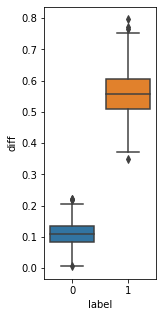

In [49]:
df = pd.DataFrame(data)
df["diff"] = ((df["top"] - df["bottom"]) / df[["top", "bottom"]].min(axis=1)).abs()
f, ax = plt.subplots(figsize=(2, 5))
sns.boxplot(x="label", y="diff", data=df)